In [31]:
seed = 42

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage
import random

def displayImage():
    with open("traindata.txt","r") as f:
        data = f.readlines()
        index = random.randint(0,len(data))
        index = 3

        data = [float(i) for i in data[index].split(',')] # Your list of 1040 grayscale values followed by the rotation angle (as strings)

        # Ensure the length of the data list is correct
        if len(data) != 1041:
            raise ValueError("The data list must contain exactly 1041 values, with the last being the rotation angle.")
        
        # Separate the pixel values and the rotation angle
        rotation_angle = float(data[-1])
        pixels = [int(p) for p in data[:-1]]
        
        # Reshape the pixels array to match the desired dimensions, e.g., 40x26
        width, height = 40, 26
        image_array = np.array(pixels).reshape((height, width))
        
        # Apply the rotation to the image
        rotated_image = scipy.ndimage.rotate(image_array, rotation_angle, reshape=True)
        
        # Display the image using Matplotlib
        plt.imshow(rotated_image, cmap='gray', vmin=0, vmax=255)
        plt.colorbar()  # Optional: adds a colorbar to indicate the scale
        plt.title(f"Grayscale Image {index}(Rotated {rotation_angle} degrees)")
        plt.show()


In [33]:
validClasses = [i for i in range(21)]
pixel_arrays = []
pixels_labels = []

with open("traindata.txt","r") as f:
    trainData = [i.split(",") for i in f.readlines()]


with open("trainlabels.txt","r") as f:
    trainLabels = f.readlines()

for i in range(len(trainData)):
    pixels = list(map(float,trainData[i][0:1040]))
    rotation_angle = int(float(trainData[i][-1].strip()))
    pixels = [j*(rotation_angle+1) for j in pixels]
    
    min_val = min(pixels)
    max_val = max(pixels)
    
    for j in range(1040):
        pixels[j] = (pixels[j]-min_val)/(max_val-min_val)

    pixels.append(rotation_angle)
    
    pixel_arrays.append(pixels)
    pixels_labels.append(int(trainLabels[i]))


inputData = np.array(pixel_arrays)
inputLabels = np.array(pixels_labels)

In [34]:
from sklearn.model_selection import train_test_split

x_train, x_temp,y_train,y_temp = train_test_split(inputData,inputLabels,test_size=0.3,random_state=seed)
x_test, x_val,y_test,y_val, = train_test_split(x_temp,y_temp, test_size=0.5, random_state=seed)

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [36]:
class Model(nn.Module):
    def __init__(self,in_features=1041,h1=256,h2=128,h3=64,out=21,embedding_dim=10):
        super().__init__()
        self.fc1 = nn.Linear(in_features,h1)
        self.fc2 = nn.Linear(h1,h2)
        self.fc3 = nn.Linear(h2,h3)
        self.out = nn.Linear(h3,out)

    def forward(self,x):
        x = F.sigmoid(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        x = self.out(x)
        return x

In [37]:
torch.manual_seed(seed)
model = Model()

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [39]:
x_train = torch.FloatTensor(x_train)
x_test = torch.FloatTensor(x_test)
x_val = torch.FloatTensor(x_val)

In [40]:
y_train = torch.LongTensor(y_train)
y_train = torch.LongTensor(y_train)
y_val = torch.LongTensor(y_val)

In [41]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)

In [42]:
def train():
    epochs = 1000
    losses = []

    maxEpochs = -1
    best_val_loss = float('inf')
    checkInterval = 1
    printInterval = int(epochs * 0.05)
    patience = 40  # Adjust this value as needed

    no_improvement_count = 0

    for epoch in range(epochs):
        model.train()
        y_pred = model(x_train)
        loss = criterion(y_pred, y_train)
        losses.append(loss.item())  # Append the loss value as a Python scalar
        if (epoch % printInterval == 0):
            print(f"Epoch: {epoch} and loss: {loss.item()}")

        # Early stopping
        if (epoch % checkInterval == 0 and epoch > 50):
            model.eval()
            with torch.no_grad():
                y_val_pred = model(x_val)
                val_loss = criterion(y_val_pred, y_val)
                
                if val_loss.item() < best_val_loss:
                    best_val_loss = val_loss.item()
                    no_improvement_count = 0  # Reset the no improvement count
                else:
                    no_improvement_count += 1
                    
                    if no_improvement_count >= patience:
                        maxEpochs = epoch
                        break
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Best epoch: {maxEpochs}")
    return maxEpochs,losses

Epoch: 0 and loss: 3.079359531402588
Epoch: 50 and loss: 2.739992380142212
Epoch: 100 and loss: 2.470252752304077
Epoch: 150 and loss: 2.2555155754089355
Epoch: 200 and loss: 2.0914552211761475
Epoch: 250 and loss: 1.8361324071884155
Epoch: 300 and loss: 1.6032350063323975
Epoch: 350 and loss: 1.4580323696136475
Epoch: 400 and loss: 1.4647718667984009
Best epoch: 432


Text(0.5, 0, 'epoch')

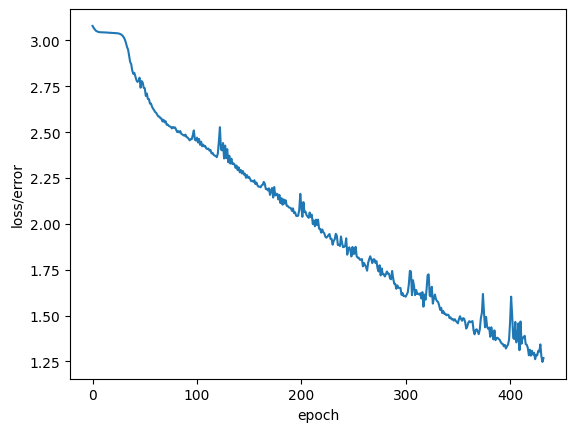

In [43]:
#graph it out
maxEpochs,losses = train()

plt.plot(range(maxEpochs+1),losses)
plt.ylabel("loss/error")
plt.xlabel("epoch")

In [44]:
import json

correct = 0
incorrect = {i: {} for i in range(21)}  # Initialize the nested dictionary

with torch.no_grad():
    y_val = model.forward(x_test)
    for i in range(len(y_val)):
        predicted_label = y_val[i].argmax().item()
        true_label = y_test[i].item()

        if predicted_label == true_label:
            correct += 1
        else:
            if predicted_label in incorrect[true_label]:
                incorrect[true_label][predicted_label] += 1
            else:
                incorrect[true_label][predicted_label] = 1

accuracy = correct / len(y_val)
print(f"Accuracy: {accuracy}")

# Save the incorrect dictionary to a JSON file
with open('incorrect_predictions.json', 'w') as json_file:
    json.dump(incorrect, json_file, indent=4)


Accuracy: 0.4358322744599746


In [45]:
# save model
torch.save(model.state_dict(),"classify.pt")